## IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from scipy import stats
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import researchpy as rp

# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.feature_selection import mutual_info_classif

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from scikeras.wrappers import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## DATA PRE-PROCESSING 1

In [2]:
df = pd.read_csv('CreditCardData.csv')
df.head(10)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1
5,#3446 698,13-Oct-20,Tuesday,20,MasterCard,Tap,£30,POS,Children,India,India,India,M,48.4,Monzo,0
6,#3652 191,13-Oct-20,Tuesday,18,Visa,CVC,£231,Online,Children,United Kingdom,United Kingdom,United Kingdom,M,39.5,Barclays,0
7,#3161 927,13-Oct-20,Tuesday,18,MasterCard,CVC,£154,Online,Services,USA,USA,United Kingdom,M,37.8,HSBC,0
8,#3025 809,13-Oct-20,Tuesday,23,MasterCard,PIN,£39,ATM,Fashion,Russia,Russia,United Kingdom,F,43.3,Metro,0
9,#3413 696,14-Oct-20,Wednesday,23,MasterCard,Tap,£17,POS,Entertainment,India,India,India,M,69.9,Barlcays,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Transaction ID          100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Day of Week             100000 non-null  object 
 3   Time                    100000 non-null  int64  
 4   Type of Card            100000 non-null  object 
 5   Entry Mode              100000 non-null  object 
 6   Amount                  99994 non-null   object 
 7   Type of Transaction     100000 non-null  object 
 8   Merchant Group          99990 non-null   object 
 9   Country of Transaction  100000 non-null  object 
 10  Shipping Address        99995 non-null   object 
 11  Country of Residence    100000 non-null  object 
 12  Gender                  99996 non-null   object 
 13  Age                     100000 non-null  float64
 14  Bank                 

In [4]:
df['Transaction ID'] = df['Transaction ID'].str.replace('#', '')

In [5]:
df['Amount'] = df['Amount'].apply(lambda x: int(x.replace('£', '')) if pd.notna(x) else x)

In [6]:
check_amount = df[df['Amount'].isnull()]
print(check_amount.to_string())

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount Type of Transaction Merchant Group Country of Transaction Shipping Address Country of Residence Gender   Age      Bank  Fraud
34456       2550 256  13-Oct-20     Tuesday     1   MasterCard        CVC     NaN              Online       Children                    USA              USA       United Kingdom      M  24.7  Barclays      1
35068       2550 306  14-Oct-20   Wednesday    11         Visa        Tap     NaN                 POS       Services         United Kingdom            China       United Kingdom      M  34.2   Halifax      1
61927       2550 318  13-Oct-20     Tuesday    15         Visa        PIN     NaN                 ATM     Restaurant                    USA              USA                  USA      F  61.1     Monzo      0
80125       2550 291  13-Oct-20     Tuesday     5   MasterCard        CVC     NaN              Online     Restaurant                 Russia           Russia       Unite

In [7]:
check_amount = df[df['Amount'].isnull()]

similar_rows = df[df['Date'].isin(check_amount['Date']) & 
                  df['Day of Week'].isin(check_amount['Day of Week']) &
                  df['Type of Card'].isin(check_amount['Type of Card']) &
                  df['Entry Mode'].isin(check_amount['Entry Mode']) &
                  df['Type of Transaction'].isin(check_amount['Type of Transaction']) &
                  df['Merchant Group'].isin(check_amount['Merchant Group']) &
                  df['Country of Transaction'].isin(check_amount['Country of Transaction']) &
                  df['Shipping Address'].isin(check_amount['Shipping Address']) &
                  df['Country of Residence'].isin(check_amount['Country of Residence']) &
                  df['Gender'].isin(check_amount['Gender']) &
                  df['Age'].isin(check_amount['Age']) &
                  df['Bank'].isin(check_amount['Bank'])]

check_anomaly = similar_rows['Fraud'] == 1
anomaly_rows = similar_rows[check_anomaly]

sorted_anomaly_rows = anomaly_rows.sort_values(by=['Date', 'Day of Week', 'Country of Transaction', 'Shipping Address', 'Country of Residence'])
print(sorted_anomaly_rows.to_string())

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount Type of Transaction Merchant Group Country of Transaction Shipping Address Country of Residence Gender   Age      Bank  Fraud
8092        2902 482  13-Oct-20     Tuesday    14   MasterCard        CVC    20.0              Online       Services                 Russia           Russia       United Kingdom      M  37.6   Halifax      1
15867       3276 931  13-Oct-20     Tuesday     6   MasterCard        PIN   187.0                 POS       Children                 Russia           Russia       United Kingdom      M  53.2  Barclays      1
40902       2939 323  13-Oct-20     Tuesday    10   MasterCard        CVC    25.0              Online       Children                 Russia           Russia       United Kingdom      M  37.6     Monzo      1
80125       2550 291  13-Oct-20     Tuesday     5   MasterCard        CVC     NaN              Online     Restaurant                 Russia           Russia       Unite

In [8]:
check_amount = df[df['Amount'].isnull()]
print(check_amount.to_string())

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount Type of Transaction Merchant Group Country of Transaction Shipping Address Country of Residence Gender   Age      Bank  Fraud
34456       2550 256  13-Oct-20     Tuesday     1   MasterCard        CVC     NaN              Online       Children                    USA              USA       United Kingdom      M  24.7  Barclays      1
35068       2550 306  14-Oct-20   Wednesday    11         Visa        Tap     NaN                 POS       Services         United Kingdom            China       United Kingdom      M  34.2   Halifax      1
61927       2550 318  13-Oct-20     Tuesday    15         Visa        PIN     NaN                 ATM     Restaurant                    USA              USA                  USA      F  61.1     Monzo      0
80125       2550 291  13-Oct-20     Tuesday     5   MasterCard        CVC     NaN              Online     Restaurant                 Russia           Russia       Unite

In [9]:
check_merchant = df[df['Merchant Group'].isnull()]
print(check_merchant.to_string())

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount Type of Transaction Merchant Group Country of Transaction Shipping Address Country of Residence Gender   Age      Bank  Fraud
286         2550 151  13-Oct-20     Tuesday    13         Visa        PIN    19.0                 ATM            NaN         United Kingdom   United Kingdom       United Kingdom      F  52.9  Barclays      0
1720        2550 654  14-Oct-20   Wednesday    10         Visa        PIN   204.0                 ATM            NaN         United Kingdom              USA       United Kingdom      M  33.9       RBS      0
2092        2550 150  14-Oct-20   Wednesday    21         Visa        CVC    11.0              Online            NaN                  India            India                India      M  48.9    Lloyds      0
6404        2550 074  14-Oct-20   Wednesday    21   MasterCard        PIN    30.0                 ATM            NaN         United Kingdom   United Kingdom       Unite

In [10]:
check_shipping = df[df['Shipping Address'].isnull()]
print(check_shipping.to_string())

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount Type of Transaction Merchant Group Country of Transaction Shipping Address Country of Residence Gender   Age      Bank  Fraud
4913        2550 516  14-Oct-20   Wednesday    20   MasterCard        CVC    27.0              Online         Gaming                    USA              NaN                  USA      F  51.0     Metro      0
6208        2550 472  14-Oct-20   Wednesday    17   MasterCard        PIN     5.0                 ATM           Food         United Kingdom              NaN       United Kingdom      F  42.6   Halifax      0
8299        2550 517  14-Oct-20   Wednesday    17   MasterCard        CVC    13.0              Online       Children                  China              NaN                China      M  50.5  Barclays      0
8436        2550 479  13-Oct-20     Tuesday     9   MasterCard        PIN    20.0                 ATM       Children         United Kingdom              NaN       Unite

In [11]:
check_gender = df[df['Gender'].isnull()]
print(check_gender.to_string())

      Transaction ID       Date Day of Week  Time Type of Card Entry Mode  Amount Type of Transaction Merchant Group Country of Transaction Shipping Address Country of Residence Gender   Age      Bank  Fraud
383         2550 715  14-Oct-20   Wednesday    15         Visa        PIN   243.0                 ATM       Products                 Russia           Russia               Russia    NaN  41.0  Barclays      0
60272       2550 678  14-Oct-20   Wednesday    13         Visa        PIN    95.0                 ATM            NaN         United Kingdom              USA       United Kingdom    NaN  51.4  Barlcays      0
91322       2550 709  13-Oct-20     Tuesday    13   MasterCard        CVC     8.0              Online            NaN         United Kingdom   United Kingdom       United Kingdom    NaN  34.3      HSBC      0
93311       2550 729  13-Oct-20     Tuesday    18   MasterCard        CVC   282.0              Online     Restaurant         United Kingdom            India       Unite

In [12]:
rows_to_delete_null = ['Amount', 'Merchant Group', 'Shipping Address', 'Gender']
df.dropna(subset=rows_to_delete_null, inplace=True)

In [13]:
df['Different Country'] = np.where(df['Country of Transaction'] != df['Country of Residence'], 'Yes', 'No')

In [14]:
df['Time'] = df['Time'].replace(24, 0)

In [15]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

In [16]:
convert_to_int = ['Amount', 'Age']

for col in convert_to_int:
    df[col] = df[col].astype('int64')

In [17]:
df['Fraud'] = df['Fraud'].replace({0: 'No', 1: 'Yes'})

In [18]:
for column in df.select_dtypes(include=['object']).columns:
    if column != 'Transaction ID':
        print(f"Value counts for column {column}:\n{df[column].value_counts()}\n")

Value counts for column Day of Week:
Day of Week
Wednesday    50166
Tuesday      49785
Friday          14
Thursday        12
Name: count, dtype: int64

Value counts for column Type of Card:
Type of Card
Visa          53800
MasterCard    46177
Name: count, dtype: int64

Value counts for column Entry Mode:
Entry Mode
PIN    49966
CVC    33470
Tap    16541
Name: count, dtype: int64

Value counts for column Type of Transaction:
Type of Transaction
Online    33470
ATM       33265
POS       33242
Name: count, dtype: int64

Value counts for column Merchant Group:
Merchant Group
Children         10676
Restaurant       10074
Services         10015
Gaming           10010
Fashion           9987
Subscription      9976
Food              9846
Entertainment     9839
Products          9838
Electronics       9716
Name: count, dtype: int64

Value counts for column Country of Transaction:
Country of Transaction
United Kingdom    71184
USA                7295
Russia             7255
China              715

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99977 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Transaction ID          99977 non-null  object        
 1   Date                    99977 non-null  datetime64[ns]
 2   Day of Week             99977 non-null  object        
 3   Time                    99977 non-null  int64         
 4   Type of Card            99977 non-null  object        
 5   Entry Mode              99977 non-null  object        
 6   Amount                  99977 non-null  int64         
 7   Type of Transaction     99977 non-null  object        
 8   Merchant Group          99977 non-null  object        
 9   Country of Transaction  99977 non-null  object        
 10  Shipping Address        99977 non-null  object        
 11  Country of Residence    99977 non-null  object        
 12  Gender                  99977 non-null  object     

## EXPLORATORY DATA ANALYSIS

### UNIVARIATE ANALYSIS

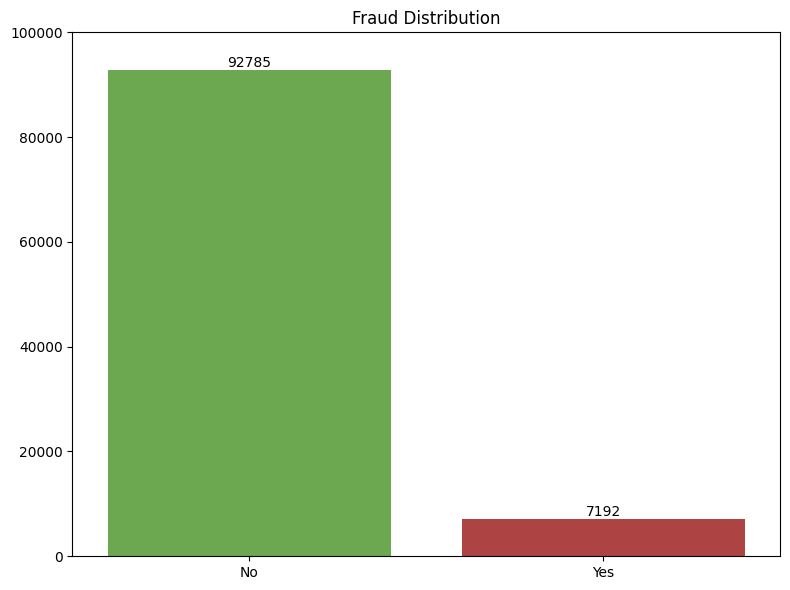

In [20]:
fraud_colors = {'Yes': '#BF3131', 'No': '#65B741'}

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=df['Fraud'], palette=fraud_colors)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('Fraud Distribution', loc='center', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
plt.ylim(0, 100000)
plt.tight_layout()
plt.show()

### BIVARIATE ANALYSIS

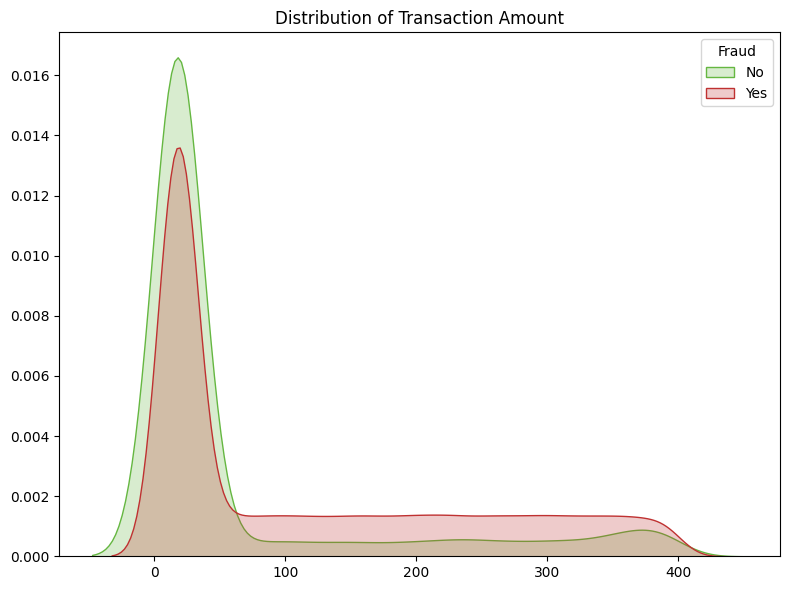

In [21]:
fraud_colors = {'No': '#BF3131', 'Yes': '#65B741'}

plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='Amount', hue='Fraud', fill=True, common_norm=False, palette=fraud_colors)

plt.title('Distribution of Transaction Amount')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Fraud', labels=df['Fraud'].unique())
plt.tight_layout()
plt.show()

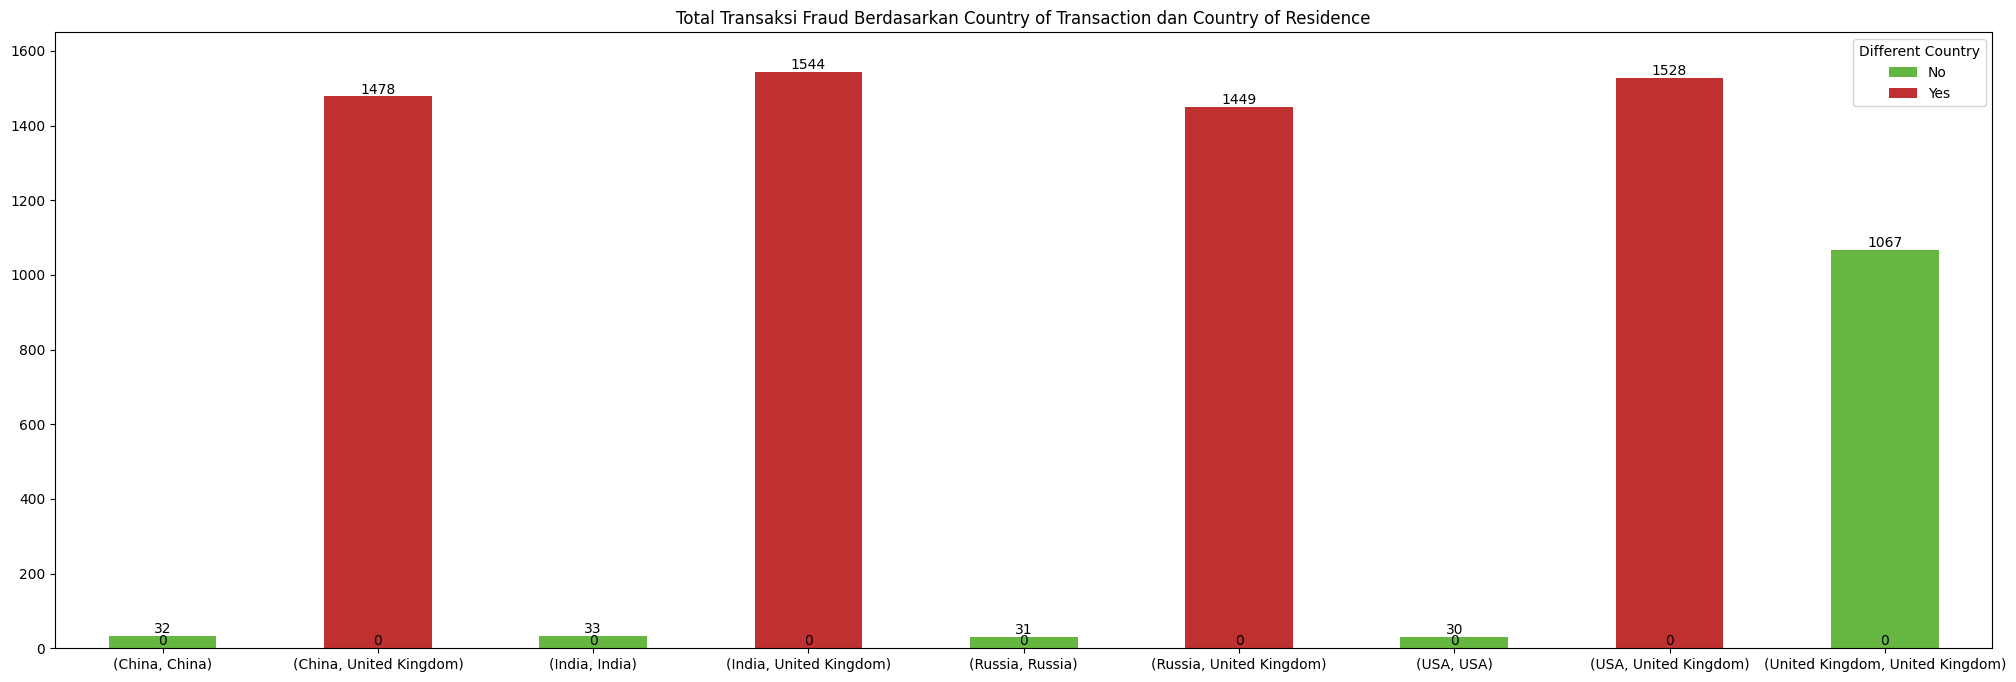

In [22]:
country_colors = {'Yes': '#BF3131', 'No': '#65B741'}

fraud_data = df[df['Fraud'] == 'Yes']
fraud_counts = fraud_data.groupby(['Country of Transaction', 'Country of Residence', 'Different Country']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(25, 8))

ax = fraud_counts.plot(kind='bar', stacked=True, color=country_colors, ax=ax)
plt.title('Total Transaksi Fraud Berdasarkan Country of Transaction dan Country of Residence')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('')
plt.ylim(0, 1650)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.legend(title='Different Country', loc='upper right')
plt.show()

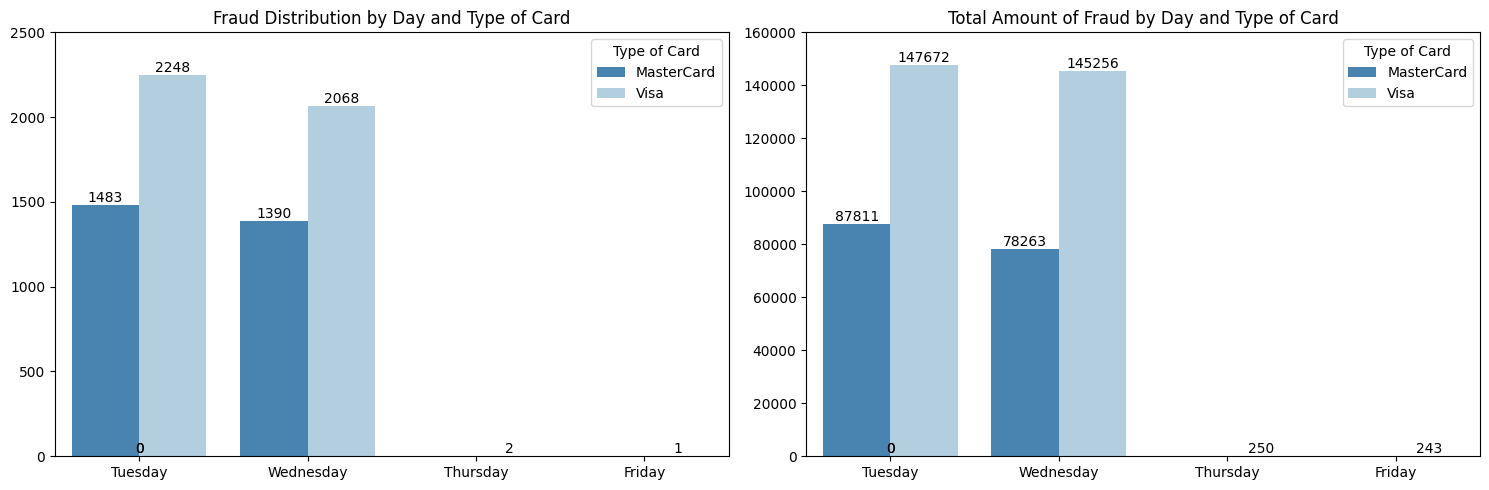

In [23]:
fraud_data = df[df['Fraud'] == 'Yes']
desired_order = ['Tuesday', 'Wednesday', 'Thursday', 'Friday']

fraud_by_day_count = fraud_data.groupby(['Day of Week', 'Type of Card']).size().reset_index(name='Number of Frauds')
fraud_by_day_count['Day of Week'] = pd.Categorical(fraud_by_day_count['Day of Week'], categories=desired_order, ordered=True)
fraud_by_day_count = fraud_by_day_count.sort_values('Day of Week')

fraud_by_day_amount = fraud_data.groupby(['Day of Week', 'Type of Card'])['Amount'].sum().reset_index(name='Total Amount')
fraud_by_day_amount['Day of Week'] = pd.Categorical(fraud_by_day_amount['Day of Week'], categories=desired_order, ordered=True)
fraud_by_day_amount = fraud_by_day_amount.sort_values('Day of Week')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1 = sns.barplot(ax=axes[0], data=fraud_by_day_count, x='Day of Week', y='Number of Frauds', hue='Type of Card', palette='Blues_r')
axes[0].set_title('Fraud Distribution by Day and Type of Card')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].legend(title='Type of Card')
axes[0].set_ylim(0, 2500)

for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black')

ax2 = sns.barplot(ax=axes[1], data=fraud_by_day_amount, x='Day of Week', y='Total Amount', hue='Type of Card', palette='Blues_r')
axes[1].set_title('Total Amount of Fraud by Day and Type of Card')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(title='Type of Card')
axes[1].set_ylim(0, 160000)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black')

plt.tight_layout()
plt.show()

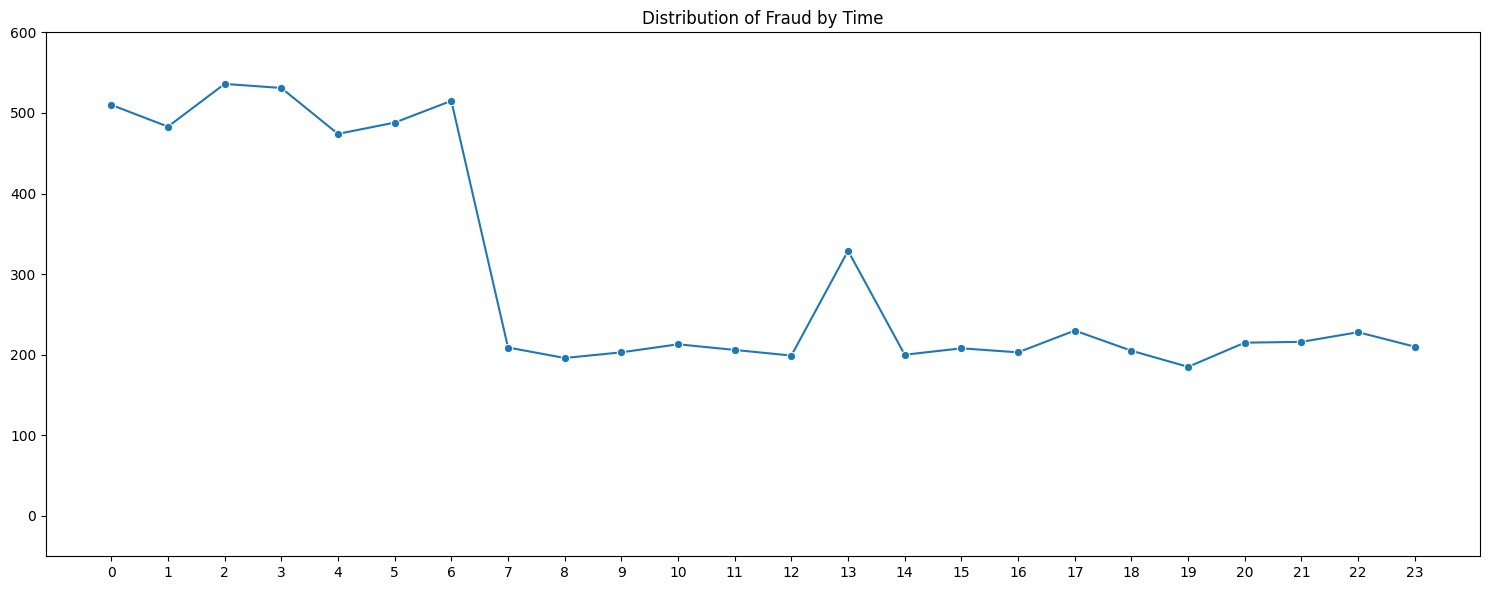

In [24]:
fraud_data = df[df['Fraud'] == 'Yes']
desired_order = df['Time'].sort_values(ascending=True).unique()

fraud_by_time = fraud_data['Time'].value_counts().sort_index().reset_index()
fraud_by_time.columns = ['Time', 'Number of Frauds']

plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='Time', y='Number of Frauds', data=fraud_by_time, marker='o', sort=True)

plt.title('Distribution of Fraud by Time', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.ylim(-50, 600)

ax.set_xticks(fraud_by_time['Time'])
plt.tight_layout()
plt.show()

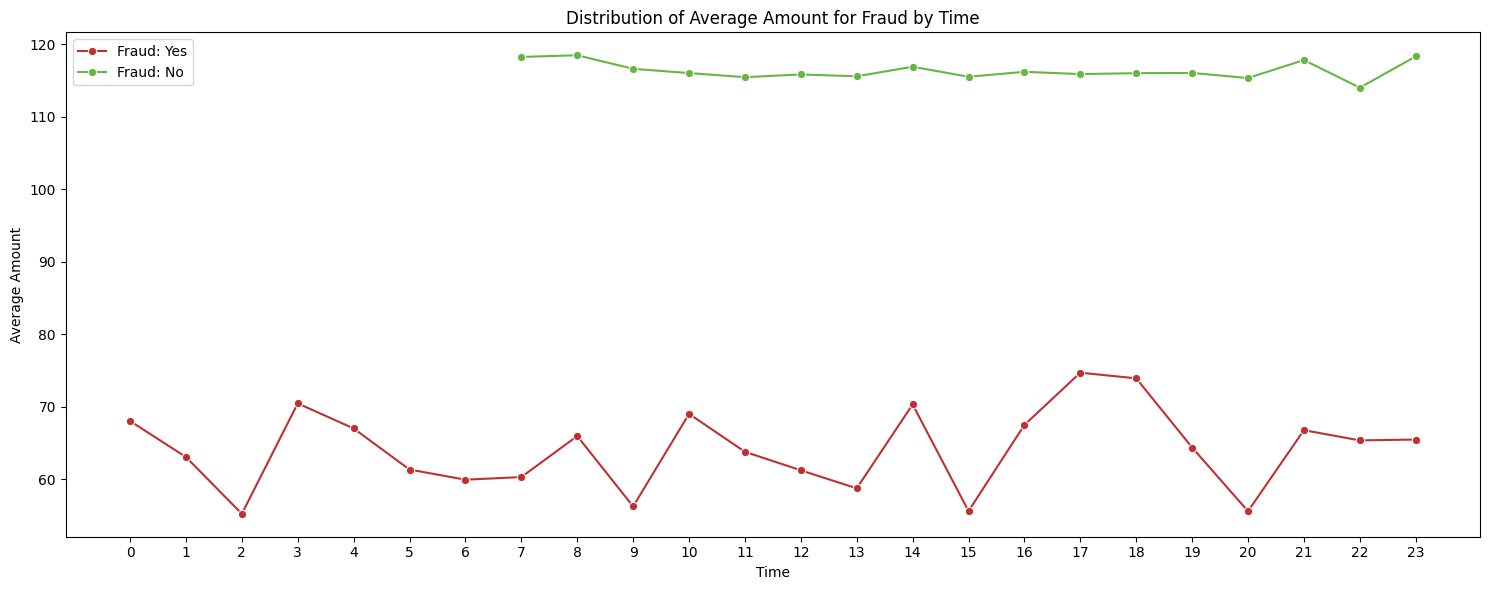

In [26]:
fraud_colors = {'Yes': '#BF3131', 'No': '#65B741'}
fraud_data_yes = df[df['Fraud'] == 'Yes']
fraud_data_no = df[df['Fraud'] == 'No']

desired_order = df['Time'].sort_values(ascending=True).unique()
fraud_amount_by_time_yes = fraud_data_yes.groupby('Time')['Amount'].mean().reindex(desired_order).reset_index()
fraud_amount_by_time_no = fraud_data_no.groupby('Time')['Amount'].mean().reindex(desired_order).reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Time', y='Amount', data=fraud_amount_by_time_yes, marker='o', sort=True, label='Fraud: Yes', color=fraud_colors['Yes'])
sns.lineplot(x='Time', y='Amount', data=fraud_amount_by_time_no, marker='o', sort=True, label='Fraud: No', color=fraud_colors['No'])

plt.title('Distribution of Average Amount for Fraud by Time', fontsize=12)
plt.xlabel('Time')
plt.ylabel('Average Amount')
plt.legend()

plt.xticks(range(24))
plt.tight_layout()
plt.show()

### MULTIVARIATE ANALYSIS

In [27]:
df.drop(columns=['Transaction ID', 'Date', 'Country of Transaction', 'Shipping Address', 'Country of Residence'], inplace=True)

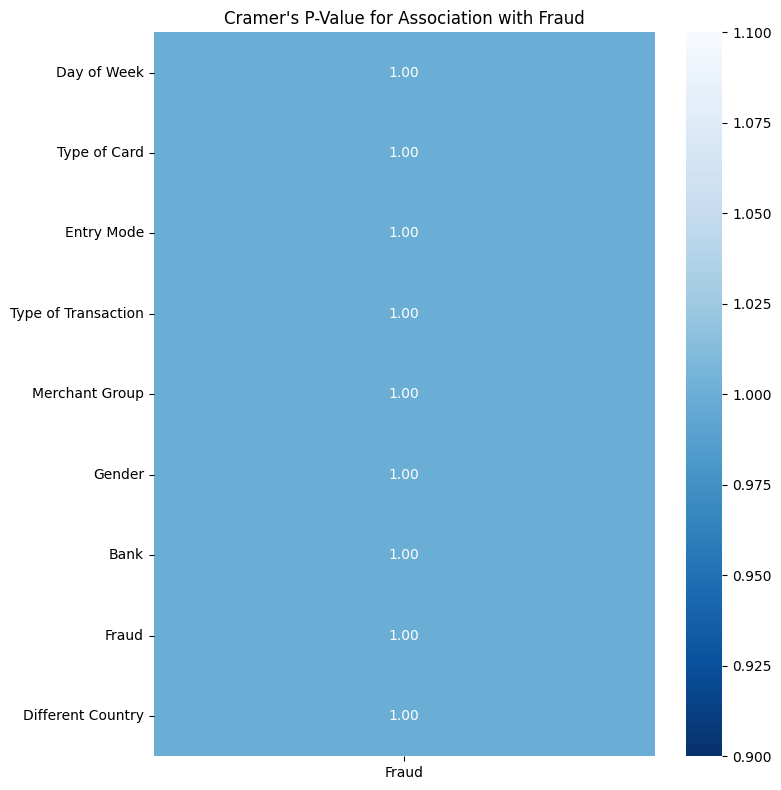

In [28]:
categorical_features = df.select_dtypes(include=['object']).columns

result = pd.DataFrame(index=categorical_features, columns=['Fraud', 'Cramer\'s P-Value'])

for i in categorical_features:
    contingency_table = pd.crosstab(df[i], df['Fraud'])
    cramers_v_result = rp.crosstab(df[i], df['Fraud'], prop='col')
    
    if 1 in cramers_v_result.columns:
        result.loc[i, 'Fraud'] = cramers_v_result.loc[1, 'p']
    else:
        result.loc[i, 'Fraud'] = 1.0

result['Fraud'] = result['Fraud'].replace({'Yes': 1, 'No': 0})

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(result[['Fraud']], annot=True, cmap='Blues_r', fmt='.2f', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='center')
plt.title('Cramer\'s P-Value for Association with Fraud')
plt.tight_layout()
plt.show()

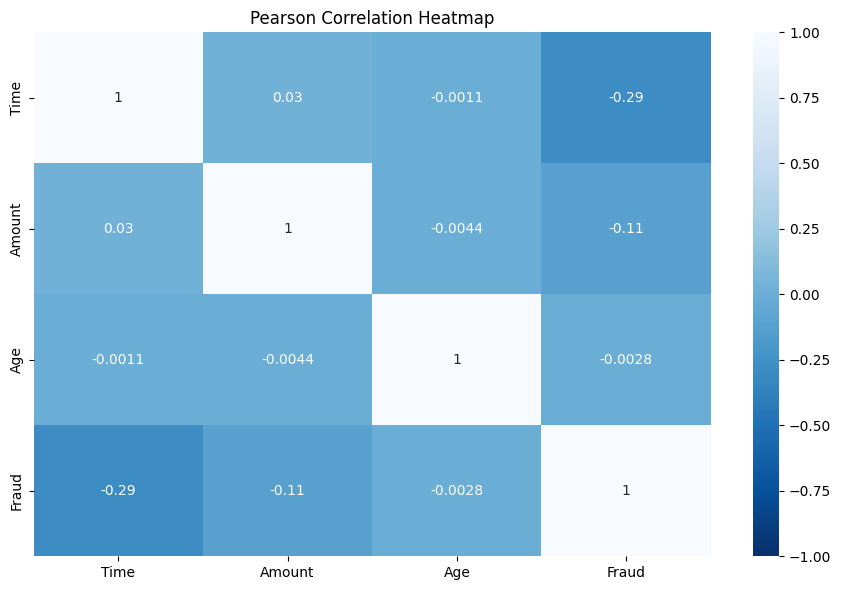

In [29]:
df['Fraud'] = df['Fraud'].replace({'Yes': 1, 'No': 0})
numerical_features = df.select_dtypes(include=['int', 'float']).columns
corr = df[numerical_features].corr()

plt.figure(figsize=(9, 6))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='Blues_r', annot_kws={'size': 10})
plt.title('Pearson Correlation Heatmap')
plt.tight_layout()
plt.show()

In [27]:
numerical_features = df.select_dtypes(include=['int', 'float']).columns
numeric = df[numerical_features]
numeric = sm.add_constant(numeric)

vif_numeric_pairwise = pd.DataFrame()
vif_numeric_pairwise['Variable'] = numeric.columns[1:]
vif_numeric_pairwise['VIF'] = [variance_inflation_factor(numeric.values, i) for i in range(1, numeric.shape[1])]

vif_threshold = 5

multicollinear_vars = []
for idx, row in vif_numeric_pairwise.iterrows():
    if row['VIF'] > vif_threshold:
        multicollinear_vars.append(row['Variable'])

print('VIF between Numerical Variables (Pairwise):')
print(vif_numeric_pairwise)
print('-'*90)

if multicollinear_vars:
    print('Multicollinearity symptoms were detected in the following variables:')
    for var in multicollinear_vars:
        print(var)
else:
    print('No multicollinearity symptoms were detected')

VIF between Numerical Variables (Pairwise):
  Variable       VIF
0     Time  1.089281
1   Amount  1.012233
2      Age  1.000034
3    Fraud  1.101595
------------------------------------------------------------------------------------------
No multicollinearity symptoms were detected


In [28]:
df.drop(columns=['Age'], inplace=True)

## DATA PRE-PROCESSING 2

### ENCODING VARIABLE

In [29]:
df = pd.get_dummies(df, columns=['Day of Week', 'Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 'Different Country', 'Gender', 'Bank'])

### DATA SPLITTING

In [30]:
X = df.drop(['Fraud'], axis=1)
y = df['Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (79981, 36), X_test shape: (19996, 36)
y_train shape: (79981,), y_test shape: (19996,)


### HANDLING IMBALANCED

In [31]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_strat, X_val_strat, y_train_strat, y_val_strat = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled, random_state=42)

print(f"X_train shape: {X_train_strat.shape}, X_test shape: {X_val_strat.shape}")
print(f"y_train shape: {y_train_strat.shape}, y_test shape: {y_val_strat.shape}")

X_train shape: (118800, 36), X_test shape: (29700, 36)
y_train shape: (118800,), y_test shape: (29700,)


### SCALING

In [32]:
X_train_strat = MinMaxScaler().fit_transform(X_train_strat)
X_val_strat = MinMaxScaler().fit_transform(X_val_strat)
X_test = MinMaxScaler().fit_transform(X_test)

## MODEL TRAINING

### TRAINING

In [33]:
model = Sequential([
    Dense(units=32, input_dim=36, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

custom_optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=custom_optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3361 (13.13 KB)
Trainable params: 3361 (13.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10, restore_best_weights=True)

history = model.fit(
    X_train_strat, y_train_strat,
    epochs=100, 
    batch_size=64,
    validation_data=(X_val_strat, y_val_strat),
    callbacks=[early_stopping]
)

best_epoch = np.argmax(history.history['val_accuracy']) + 1

print(f"\nBest Validation Accuracy occurred at Epoch {best_epoch}: {np.max(history.history['val_accuracy'])}")
print(f"Validation Accuracy at Early Stopping: {history.history['val_accuracy'][-1]}")

Epoch 1/100


1857/1857 [==============================] - 7s 3ms/step - loss: 0.0953 - accuracy: 0.9662 - val_loss: 0.0539 - val_accuracy: 0.9822
Epoch 2/100
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0525 - accuracy: 0.9827 - val_loss: 0.0481 - val_accuracy: 0.9839
Epoch 3/100
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0478 - accuracy: 0.9841 - val_loss: 0.0450 - val_accuracy: 0.9859
Epoch 4/100
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0405 - val_accuracy: 0.9876
Epoch 5/100
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0386 - accuracy: 0.9883 - val_loss: 0.0372 - val_accuracy: 0.9889
Epoch 6/100
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 0.0404 - val_accuracy: 0.9879
Epoch 7/100
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0357 - accuracy: 0.9895 - val_loss: 0.0355 - val_

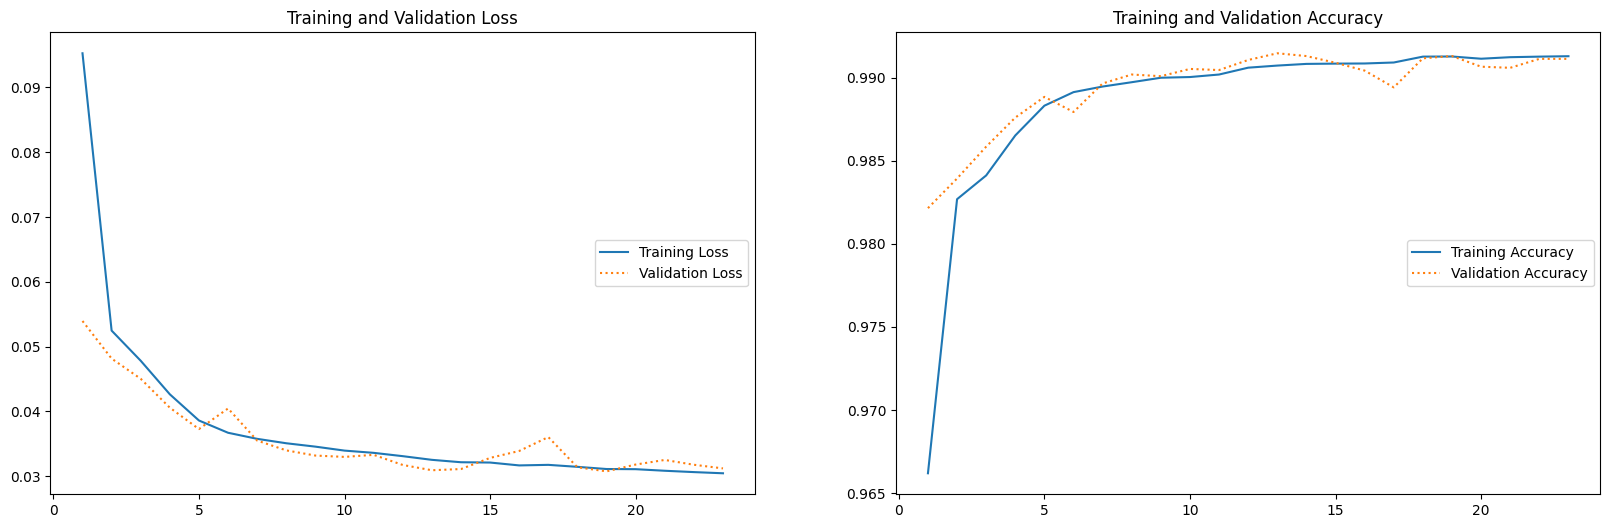

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(epochs, loss, '-', label='Training Loss')
axs[0].plot(epochs, val_loss, ':', label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].legend(loc='center right')

axs[1].plot(epochs, acc, '-', label='Training Accuracy')
axs[1].plot(epochs, val_acc, ':', label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].legend(loc='center right')

plt.show()

In [36]:
y_pred_train = model.predict(X_train_strat)
y_pred_val = model.predict(X_val_strat)

accuracy_train = accuracy_score(y_train_strat, y_pred_train > 0.5)
precision_train = precision_score(y_train_strat, y_pred_train > 0.5)
recall_train = recall_score(y_train_strat, y_pred_train > 0.5)
f1_train = f1_score(y_train_strat, y_pred_train > 0.5)
roc_auc_train = roc_auc_score(y_train_strat, y_pred_train)

accuracy_val = accuracy_score(y_val_strat, y_pred_val > 0.5)
precision_val = precision_score(y_val_strat, y_pred_val > 0.5)
recall_val = recall_score(y_val_strat, y_pred_val > 0.5)
f1_val = f1_score(y_val_strat, y_pred_val > 0.5)
roc_auc_val = roc_auc_score(y_val_strat, y_pred_val)

data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    'Validation': [accuracy_val, precision_val, recall_val, f1_val, roc_auc_val]
}

df_metrics = pd.DataFrame(data)
print()
print(df_metrics)

929/929 [==============================] - 2s 2ms/step

      Metric     Train  Validation
0   Accuracy  0.991768    0.991481
1  Precision  0.997005    0.996530
2     Recall  0.986498    0.986397
3   F1 Score  0.991724    0.991438
4    ROC AUC  0.998712    0.998620


## MODEL EVALUATION

### CHECK MODEL PERFORMACE

In [37]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred > 0.5)
precision = precision_score(y_test, y_pred > 0.5)
recall = recall_score(y_test, y_pred > 0.5)
f1 = f1_score(y_test, y_pred > 0.5)
roc_auc = roc_auc_score(y_test, y_pred)

print()
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("ROC AUC Score: {:.4f}".format(roc_auc))

625/625 [==============================] - 1s 2ms/step

Accuracy: 0.9826
Precision: 0.9372
Recall: 0.8172
F1 Score: 0.8731
ROC AUC Score: 0.9787


### CONFUSION MATRIX

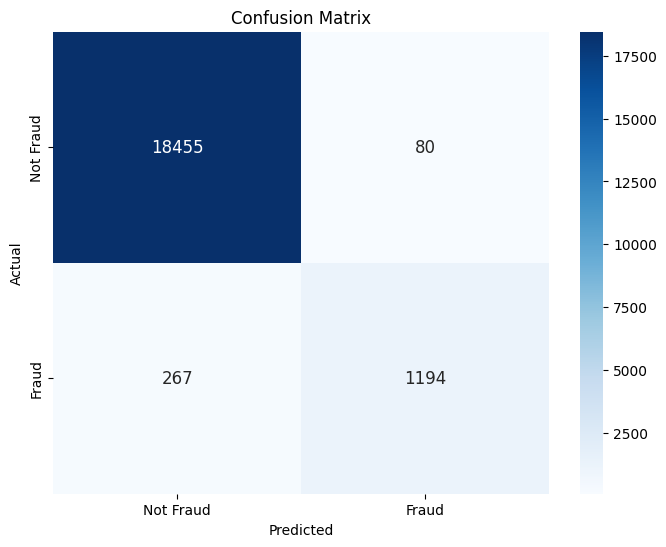

In [38]:
class_labels = ['Not Fraud', 'Fraud']

y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12},
            xticklabels=class_labels, yticklabels=class_labels, ax=axes)
axes.set_title('Confusion Matrix')
axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')

plt.show()

### FEATURE IMPORTANCE

In [39]:
features = ['Time', 'Amount', 'Fraud', 'Day of Week_Friday', 'Day of Week_Thursday', 'Day of Week_Tuesday', 'Day of Week_Wednesday', 'Type of Card_MasterCard', 
            'Type of Card_Visa', 'Entry Mode_CVC', 'Entry Mode_PIN', 'Entry Mode_Tap', 'Type of Transaction_ATM', 'Type of Transaction_Online', 'Type of Transaction_POS', 
            'Merchant Group_Children', 'Merchant Group_Electronics', 'Merchant Group_Entertainment', 'Merchant Group_Fashion', 'Merchant Group_Food', 'Merchant Group_Gaming', 
            'Merchant Group_Products', 'Merchant Group_Restaurant', 'Merchant Group_Services', 'Merchant Group_Subscription', 'Different Country_No', 'Different Country_Yes', 
            'Gender_F', 'Gender_M', 'Bank_Barclays', 'Bank_Barlcays', 'Bank_HSBC', 'Bank_Halifax', 'Bank_Lloyds', 'Bank_Metro', 'Bank_Monzo', 'Bank_RBS']

mutual_info = mutual_info_classif(X_train_strat, y_train_strat)

feature_importance_dict = dict(zip(features, mutual_info))
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Variable', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                        Variable  Importance
24   Merchant Group_Subscription    0.465055
25          Different Country_No    0.344637
0                           Time    0.225825
1                         Amount    0.061166
9                 Entry Mode_CVC    0.046390
26         Different Country_Yes    0.027361
6          Day of Week_Wednesday    0.021556
21       Merchant Group_Products    0.018612
16    Merchant Group_Electronics    0.016593
22     Merchant Group_Restaurant    0.016133
5            Day of Week_Tuesday    0.015674
20         Merchant Group_Gaming    0.015413
11                Entry Mode_Tap    0.015067
18        Merchant Group_Fashion    0.014357
32                  Bank_Halifax    0.013485
4           Day of Week_Thursday    0.013395
35                    Bank_Monzo    0.013116
29                 Bank_Barclays    0.012939
23       Merchant Group_Services    0.012595
30                 Bank_Barlcays    0.012252
33                   Bank_Lloyds    0.011529
19        